In [7]:
import pandas as pd
import numpy as np
from pysyncon import Dataprep, Synth
import random
import pickle
from sklearn.neighbors import KDTree

In [8]:
treated_unit = '1156007487'
treated_period = 2017
id_var = 'pidp'
time_var = 'year'
target_var = 'ind_inc_deflated'
df = pd.read_csv('./test_data.csv', index_col=0)
df['pidp'] = df['pidp'].astype(str)
t_u = df[df.pidp==treated_unit].copy()
c_u = df[df.pidp!=treated_unit].copy()
selection = random.sample(c_u.pidp.unique().tolist(), 500)
sample = df[df.pidp.isin(selection)]
data = pd.concat([sample,t_u], axis=0)

In [14]:
df

,year,pidp,asian,black,dvage,ind_inc_deflated,low,mastat_recoded,middle,mixed,other
0,2010.0,884029255,0.0,0.0,22.0,975.979710,1.0,0.0,0.0,0.0,0.0
1,2011.0,884029255,0.0,0.0,23.0,1194.095368,1.0,0.0,0.0,0.0,0.0
2,2012.0,884029255,0.0,0.0,24.0,1055.966209,1.0,0.0,0.0,0.0,0.0
3,2013.0,884029255,0.0,0.0,25.0,1230.769231,1.0,0.0,0.0,0.0,0.0
4,2014.0,884029255,0.0,0.0,26.0,1093.168472,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
13039,2017.0,1634453451,1.0,0.0,42.0,0.000000,0.0,1.0,0.0,0.0,0.0
13040,2018.0,1634453451,1.0,0.0,43.0,0.000000,0.0,1.0,0.0,0.0,0.0
13041,2019.0,1634453451,1.0,0.0,44.0,0.000000,0.0,1.0,0.0,0.0,0.0
13042,2020.0,1634453451,1.0,0.0,45.0,0.000000,0.0,1.0,0.0,0.0,0.0


In [11]:
round(1/df.drop(columns=['year', 'pidp']).var(), 4).tolist()

[14.0231, 34.9964, 0.0041, 0.0, 5.169, 4.5588, 6.2474, 58.2239, 272.7328]

In [20]:
with open('samples_fc.pkl', 'rb') as file:
    data_object = pickle.load(file)[0]

In [32]:
data = data_object['data'].copy()
ncol = data.shape[1] - 1
sample_weights = data_object['weight'].copy()
data.index.names = ['var', 'year']
t_time = data_object['treat_time']
target_var = data_object['target_var']
treated_unit = data_object['treat_id']
data.index = data.index.map(lambda idx: (idx[0], idx[1] - t_time))
sample_weights.index = sample_weights.index - t_time
data = data.sort_index(ascending=True).copy()
#data = data.loc[(slice(None), slice(-5, 5)), :].copy()
df_T0 = data.loc[pd.IndexSlice[:, :-1], :]
kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
idx = kdt.query(df_T0.T, k=50, return_distance=False)[0, :]
data = data.iloc[:, idx]

In [33]:
data.index.get_level_values('year').min().astype(int)

-7

In [35]:
melted_df = data.reset_index().melt(id_vars=['var', 'year'], var_name='pidp')
pivoted_df = melted_df.pivot(index=['year', 'pidp'], columns='var', values='value').reset_index()
pivoted_df =pivoted_df.sort_values(by=['pidp', 'year'])
pivoted_df = pivoted_df.reset_index(drop=True)
pivoted_df.columns.name = ''
controls = pivoted_df.pidp[pivoted_df.pidp!=treated_unit].unique()
pivoted_df

/tmp/ipykernel_43295/1654835939.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_df = melted_df.pivot(index=['year', 'pidp'], columns='var', values='value').reset_index()


,year,pidp,asian,black,dvage,ind_inc_deflated,low,mastat_recoded,middle,mixed,other
0,-7.0,884086367,1.0,0.0,37.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-6.0,884086367,1.0,0.0,38.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-5.0,884086367,1.0,0.0,39.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-4.0,884086367,1.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-3.0,884086367,1.0,0.0,41.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
545,0.0,1634234491,1.0,0.0,52.0,0.0,0.0,1.0,0.0,0.0,0.0
546,1.0,1634234491,1.0,0.0,54.0,0.0,0.0,1.0,0.0,0.0,0.0
547,2.0,1634234491,1.0,0.0,54.0,0.0,0.0,1.0,0.0,0.0,0.0
548,3.0,1634234491,1.0,0.0,55.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
dataprep = Dataprep(
    foo=pivoted_df,
    predictors=['ind_inc_deflated', 'asian', 'black', 'dvage', 'low', 'mastat_recoded', 'middle', 'mixed', 'other'],
    predictors_op="mean",
    time_predictors_prior=range(-5, 1),
    dependent="ind_inc_deflated",
    unit_variable="pidp",
    time_variable="year",
    treatment_identifier=treated_unit,
    controls_identifier=controls,
    time_optimize_ssr=range(-5, 1),
)


In [45]:
dataprep.make_outcome_mats()

(pidp  884086367   884286287   884306011   884418211   885185247   885927127   \
 year                                                                           
 -5.0         0.0         0.0    0.000000         0.0         0.0         0.0   
 -4.0         0.0         0.0    0.000000         0.0         0.0         0.0   
 -3.0         0.0         0.0    0.000000         0.0         0.0         0.0   
 -1.0         0.0         0.0    0.000000         0.0         0.0         0.0   
  0.0         0.0         0.0  203.463799         0.0         0.0         0.0   
 
 pidp  952236647   952998247   953022047   953082571   ...  1429560607  \
 year                                                  ...               
 -5.0         0.0         0.0         0.0         0.0  ...         0.0   
 -4.0         0.0         0.0         0.0         0.0  ...         0.0   
 -3.0         0.0         0.0         0.0         0.0  ...         0.0   
 -1.0         0.0         0.0         0.0         0.0  ...   

In [27]:
def sc_b(data_object, custom_V):
    data = data_object['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = data_object['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = data_object['treat_time']
    target_var = data_object['target_var']
    treated_unit = data_object['treat_id']
    data.index = data.index.map(lambda idx: (idx[0], idx[1] - t_time))
    sample_weights.index = sample_weights.index - t_time
    data = data.sort_index(ascending=True).copy()
    data = data.loc[(slice(None), slice(-5, 5)), :].copy()
    melted_df = data.reset_index().melt(id_vars=['var', 'year'], var_name='pidp')
    pivoted_df = melted_df.pivot(index=['year', 'pidp'], columns='var', values='value').reset_index()
    pivoted_df =pivoted_df.sort_values(by=['pidp', 'year'])
    pivoted_df = pivoted_df.reset_index(drop=True)
    pivoted_df.columns.name = ''
    controls = pivoted_df.pidp[pivoted_df.pidp!=treated_unit].unique()
    covariates = pivoted_df.columns.to_list()
    covariates.remove('year')
    covariates.remove('pidp')
    dataprep = Dataprep(
        foo=pivoted_df,
        predictors=covariates,
        predictors_op="mean",
        time_predictors_prior=range(-5, -1),
        dependent=target_var,
        unit_variable="pidp",
        time_variable="year",
        treatment_identifier=treated_unit,
        controls_identifier=controls,
        time_optimize_ssr=range(-5, -1),
    )
    synth = Synth()
    synth.fit(dataprep=dataprep, custom_V=custom_V)
    synth = data.drop(columns=treated_unit).dot(synth.W).loc[target_var] # synthetic control is now based on the new subset of observations
    treated = data[treated_unit].loc[target_var]
    diff = treated - synth
    weighted_diff = sample_weights.multiply(diff, axis=0)['weight_yearx']
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff,
        'weighted_diff': weighted_diff
         }

In [22]:
synth = Synth()
synth.fit(dataprep=dataprep, custom_V=[.4, .75, .75, .75, .75, .75, .75, .75, .75])

NameError: name 'dataprep' is not defined

<AxesSubplot: xlabel='year'>

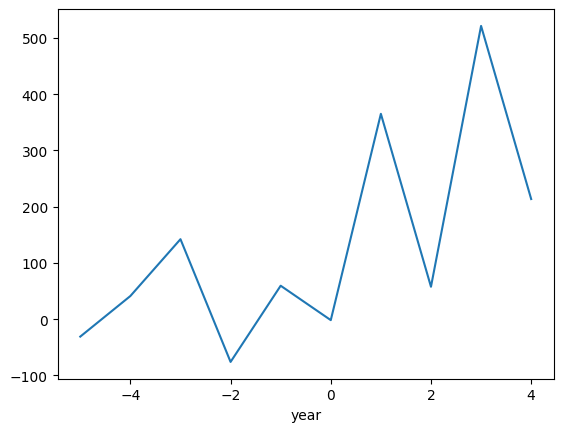

In [302]:
(data[treated_unit].loc[target_var]  - data.drop(columns=treated_unit).dot(synth.W).loc[target_var])

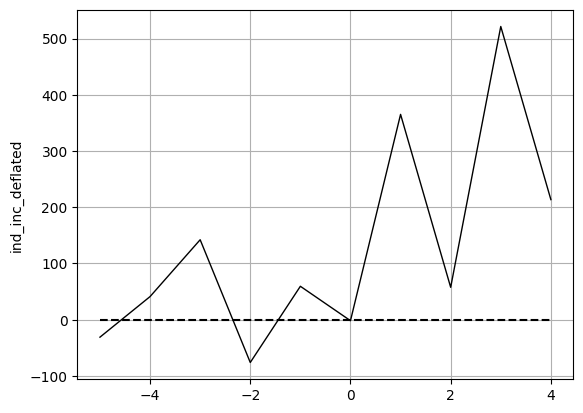

In [303]:
synth.gaps_plot(time_period=range(-5, 5))